In [1]:
# !pip install oolearning --upgrade

In [31]:
import math
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer, MinMaxScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

import oolearning as oo
from helpers import DataFrameSelector, CustomLogTransform, ChooserTransform, CombineAgeHoursTransform, CombineCapitalGainLossTransform

pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

In [3]:
csv_file = '../census.csv'
target_variable = 'income'

explore = oo.ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                   target_variable=target_variable)
negative_class = '<=50K'
positive_class = '>50K'

explore.dataset.head(20)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


In [4]:
explore.numeric_summary()

,count,nulls,perc_nulls,num_zeros,perc_zeros,mean,st_dev,coef of var,skewness,kurtosis,min,10%,25%,50%,75%,90%,max
age,45222,0,0.0,0,0.000,38.548,13.218,0.343,0.533,-0.156,17.0,22.0,28.0,37.0,47.0,57.0,90.0
education-num,45222,0,0.0,0,0.000,10.118,2.553,0.252,-0.311,0.635,1.0,7.0,9.0,10.0,13.0,13.0,16.0
capital-gain,45222,0,0.0,41432,0.916,1101.430,7506.430,6.815,11.789,150.151,0.0,0.0,0.0,0.0,0.0,0.0,99999.0
capital-loss,45222,0,0.0,43082,0.953,88.595,404.956,4.571,4.516,19.364,0.0,0.0,0.0,0.0,0.0,0.0,4356.0
hours-per-week,45222,0,0.0,0,0.000,40.938,12.008,0.293,0.341,3.201,1.0,25.0,40.0,40.0,45.0,55.0,99.0


In [5]:
explore.categoric_summary()

,count,nulls,perc_nulls,top,unique,perc_unique
workclass,45222,0,0.0,Private,7,0.000
education_level,45222,0,0.0,HS-grad,16,0.000
marital-status,45222,0,0.0,Married-civ-spouse,7,0.000
occupation,45222,0,0.0,Craft-repair,14,0.000
relationship,45222,0,0.0,Husband,6,0.000
race,45222,0,0.0,White,5,0.000
sex,45222,0,0.0,Male,2,0.000
native-country,45222,0,0.0,United-States,41,0.001
income,45222,0,0.0,<=50K,2,0.000


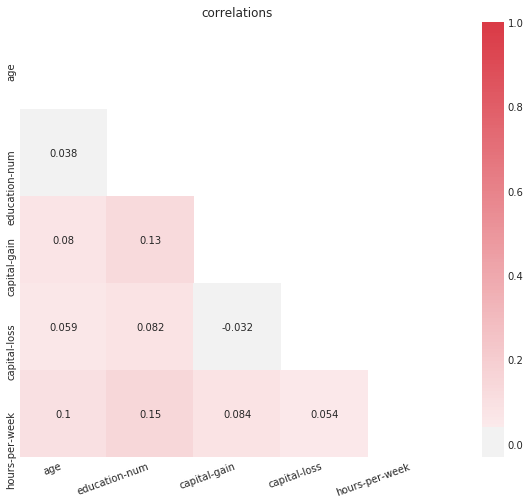

In [6]:
explore.plot_correlation_heatmap()

In [7]:
# NOTE: since I will be cross-validating transformations e.g. GridSearchCV, it typically won't work to
# one-hot-encode during cross-validation because the holdout fold will tend to have categoric values that
# weren't found in the training folds, and therefore will break during transformation because it will encode
# a value (i.e. add a column) that didn't exist in the training folds.
# So, for this, we need to fit ALL data. Then, below if we have new data e.g. Kaggle, we have to apply
# the same pipeline (i.e.  cat_encoding_pipeline.transform()
# TODO: this breaks though if there are any categorical features with missing values in the final test/Kaggle set
one_hot_transformer = oo.DummyEncodeTransformer(encoding=oo.CategoricalEncoding.ONE_HOT)
transformed_data = one_hot_transformer.fit_transform(explore.dataset.drop(columns=target_variable))
transformed_data[target_variable] = explore.dataset[target_variable]

# Transformations & Transformation Tuning Parameters

define the transformations we want to do, some transformations will have parameters (e.g. base of log tranform (or no transform), type of scaling, whether or not to add column combinations (e.g. age * hours-per-week)

Below is the pipeline for captail-gain/lost. 

We want to tune whether or not we should log transform. We need to do this after imputing but before scaling, so it needs to be it's own pipeline.

In [8]:
cap_gain_loss_pipeline = Pipeline([
        ('selector', DataFrameSelector(attribute_names=['capital-gain', 'capital-loss'])),
        ('imputer', Imputer()),
        # tune Log trasformation base (or no transformation)
        ('custom_transform', CustomLogTransform(base=math.e)),
        # tune "net gain" (have to do it after log transform
        ('custom_cap_gain_minus_loss', CombineCapitalGainLossTransform(combine=True)),
        # tune MinMax vs StandardScaler
        ('custom_scaler', ChooserTransform(base_transformer=MinMaxScaler())),
    ])

Below is the pipeline for the rest of numeric features:

In [9]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(attribute_names=['age', 'education-num', 'hours-per-week'])),
        ('imputer', Imputer()),
        # tune age * hours-per-week; update: tuned -chose not to include
        #('combine_agehours', CombineAgeHoursTransform()),
        # tune MinMax vs StandardScaler; update: tuned - chose MinMax
        ('custom_scaler', ChooserTransform(base_transformer=MinMaxScaler())),
    ])

Pipeline that simply gets the categorical/encoded columns from the previous transformation (which used `oo-learning`)

In [10]:
append_categoricals = Pipeline([
        ('append_cats', DataFrameSelector(attribute_names=one_hot_transformer.encoded_columns))  # already encoded
    ])

Below is the pipeline for combining all of the other pipelines

In [11]:
# combine pipelines
transformations_pipeline = FeatureUnion(transformer_list=[
        ("cap_gain_loss_pipeline", cap_gain_loss_pipeline),
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", append_categoricals),
    ])

Choose the transformations to tune, below:

In [12]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(
                                                                 max_depth=5,
                                                                 min_samples_split=500,
                                                                 min_samples_leaf=50,
                                                                 max_features='sqrt',
                                                                ),
                                    n_estimators=50,
                                    learning_rate=0.1,
                                    random_state=12)

In [13]:
from scipy.stats import randint, uniform, expon
model_param_dict = {
          'model__n_estimators': randint(50, 2000),
          'model__base_estimator__max_features': uniform(.2, .8),
          'model__base_estimator__max_depth': randint(3, 100),
          'model__base_estimator__min_samples_split': uniform(0.001, 0.4),
          'model__base_estimator__min_samples_leaf': uniform(0.001, 0.4),          
        }

In [14]:
full_pipeline = Pipeline([
    ('preparation', transformations_pipeline),
    #('pca_chooser', ChooserTransform()),
    #('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('model', model)
])

Tuning strategy according to https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [15]:
# actual hyper-parameters/options to tune for transformations.
transformation_parameters = {
         #'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],  # tune strategy
         #'pca_chooser__base_transformer': [PCA(n_components=0.95, random_state=42), None],  # PCA vs not
         #'preparation__cap_gain_loss_pipeline__custom_transform__base': [None, math.e],  # Log transform (base e) or not
         #'preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine': [True, False],
#         'preparation__cap_gain_loss_pipeline__custom_scaler__base_transformer': [MinMaxScaler(), StandardScaler()],
         #'preparation__num_pipeline__combine_agehours__combine': [True, False],
 #        'preparation__num_pipeline__custom_scaler__base_transformer': [MinMaxScaler(), StandardScaler()],


    }

In [16]:
# def binary_roc_auc(y_true, y_score):
#     return roc_auc_score(y_true=y_true,
#                          # binary makes it so it converts the "scores" to predictions
#                          y_score=[1 if x > 0.5 else 0 for x in y_score])

scorer = make_scorer(roc_auc_score, greater_is_better=True)

In [17]:
y =  transformed_data[target_variable].apply(lambda x: 1 if x == positive_class else 0)

In [18]:
transformed_data[target_variable].values[0:10]

array(['<=50K', '<=50K', '<=50K', '<=50K', '<=50K', '<=50K', '<=50K',
       '>50K', '>50K', '>50K'], dtype=object)

In [19]:
y[0:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    1
Name: income, dtype: int64

In [20]:
param_grid = {**transformation_parameters, **model_param_dict}
param_grid

{'model__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen at 0x110300160>,
 'model__base_estimator__max_features': <scipy.stats._distn_infrastructure.rv_frozen at 0x110300908>,
 'model__base_estimator__max_depth': <scipy.stats._distn_infrastructure.rv_frozen at 0x110300ac8>,
 'model__base_estimator__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen at 0x110300cc0>,
 'model__base_estimator__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen at 0x110300978>}

In [21]:
print('Starting....')
time_start = time.time()
from sklearn.model_selection import RandomizedSearchCV
grid_search = RandomizedSearchCV(estimator=full_pipeline,
                                 param_distributions=model_param_dict,
                                 n_iter=100,
                                 cv=RepeatedKFold(n_splits=5, n_repeats=1),
                                 scoring=scorer,
                                 return_train_score=True,
                                 n_jobs=-1,
                                 verbose=2)
grid_search.fit(transformed_data.drop(columns=target_variable), y)
time_end = time.time()

Starting....
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] model__base_estimator__max_depth=75, model__base_estimator__max_features=0.5111017917434557, model__base_estimator__min_samples_leaf=0.3390780963031168, model__base_estimator__min_samples_split=0.041186450968035374, model__n_estimators=1344 
[CV] model__base_estimator__max_depth=75, model__base_estimator__max_features=0.5111017917434557, model__base_estimator__min_samples_leaf=0.3390780963031168, model__base_estimator__min_samples_split=0.041186450968035374, model__n_estimators=1344 
[CV] model__base_estimator__max_depth=75, model__base_estimator__max_features=0.5111017917434557, model__base_estimator__min_samples_leaf=0.3390780963031168, model__base_estimator__min_samples_split=0.041186450968035374, model__n_estimators=1344 
[CV] model__base_estimator__max_depth=75, model__base_estimator__max_features=0.5111017917434557, model__base_estimator__min_samples_leaf=0.3390780963031168, model__base_estimator__mi

[CV] model__base_estimator__max_depth=21, model__base_estimator__max_features=0.563076831059474, model__base_estimator__min_samples_leaf=0.2594525264640068, model__base_estimator__min_samples_split=0.28337674071929825, model__n_estimators=703 
[CV]  model__base_estimator__max_depth=33, model__base_estimator__max_features=0.7189455286940476, model__base_estimator__min_samples_leaf=0.2740366014203196, model__base_estimator__min_samples_split=0.023535166580018554, model__n_estimators=414, total= 1.3min
[CV] model__base_estimator__max_depth=21, model__base_estimator__max_features=0.563076831059474, model__base_estimator__min_samples_leaf=0.2594525264640068, model__base_estimator__min_samples_split=0.28337674071929825, model__n_estimators=703 
[CV]  model__base_estimator__max_depth=33, model__base_estimator__max_features=0.7189455286940476, model__base_estimator__min_samples_leaf=0.2740366014203196, model__base_estimator__min_samples_split=0.023535166580018554, model__n_estimators=414, tota

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 23.1min


[CV]  model__base_estimator__max_depth=64, model__base_estimator__max_features=0.26476833485577284, model__base_estimator__min_samples_leaf=0.00892060725839412, model__base_estimator__min_samples_split=0.07532039434488634, model__n_estimators=1780, total=22.6min
[CV] model__base_estimator__max_depth=50, model__base_estimator__max_features=0.4712682944156237, model__base_estimator__min_samples_leaf=0.09635281598948986, model__base_estimator__min_samples_split=0.046855793348388165, model__n_estimators=502 
[CV]  model__base_estimator__max_depth=50, model__base_estimator__max_features=0.4712682944156237, model__base_estimator__min_samples_leaf=0.09635281598948986, model__base_estimator__min_samples_split=0.046855793348388165, model__n_estimators=502, total= 2.6min
[CV] model__base_estimator__max_depth=50, model__base_estimator__max_features=0.4712682944156237, model__base_estimator__min_samples_leaf=0.09635281598948986, model__base_estimator__min_samples_split=0.046855793348388165, model_

[CV] model__base_estimator__max_depth=29, model__base_estimator__max_features=0.2499555060773794, model__base_estimator__min_samples_leaf=0.31909066135117026, model__base_estimator__min_samples_split=0.08898940796214604, model__n_estimators=978 
[CV]  model__base_estimator__max_depth=29, model__base_estimator__max_features=0.2499555060773794, model__base_estimator__min_samples_leaf=0.31909066135117026, model__base_estimator__min_samples_split=0.08898940796214604, model__n_estimators=978, total= 2.3min
[CV] model__base_estimator__max_depth=90, model__base_estimator__max_features=0.22550281179491602, model__base_estimator__min_samples_leaf=0.0504424094076249, model__base_estimator__min_samples_split=0.17126418696390364, model__n_estimators=1013 
[CV]  model__base_estimator__max_depth=29, model__base_estimator__max_features=0.2499555060773794, model__base_estimator__min_samples_leaf=0.31909066135117026, model__base_estimator__min_samples_split=0.08898940796214604, model__n_estimators=978,

[CV]  model__base_estimator__max_depth=68, model__base_estimator__max_features=0.866256066055517, model__base_estimator__min_samples_leaf=0.29327002446402456, model__base_estimator__min_samples_split=0.24494470813826047, model__n_estimators=1038, total= 6.5min
[CV] model__base_estimator__max_depth=89, model__base_estimator__max_features=0.21217462807233628, model__base_estimator__min_samples_leaf=0.07723109645402258, model__base_estimator__min_samples_split=0.2905030876924605, model__n_estimators=1514 
[CV]  model__base_estimator__max_depth=90, model__base_estimator__max_features=0.3407647417557883, model__base_estimator__min_samples_leaf=0.24209668772551385, model__base_estimator__min_samples_split=0.19863951106150338, model__n_estimators=1566, total= 5.6min
[CV] model__base_estimator__max_depth=89, model__base_estimator__max_features=0.21217462807233628, model__base_estimator__min_samples_leaf=0.07723109645402258, model__base_estimator__min_samples_split=0.2905030876924605, model__n_

[CV] model__base_estimator__max_depth=79, model__base_estimator__max_features=0.674288456635779, model__base_estimator__min_samples_leaf=0.020486175803511555, model__base_estimator__min_samples_split=0.39603971209667976, model__n_estimators=1696 
[CV]  model__base_estimator__max_depth=8, model__base_estimator__max_features=0.5544833982013653, model__base_estimator__min_samples_leaf=0.12765974842787065, model__base_estimator__min_samples_split=0.3466615795912992, model__n_estimators=836, total= 3.6min
[CV] model__base_estimator__max_depth=79, model__base_estimator__max_features=0.674288456635779, model__base_estimator__min_samples_leaf=0.020486175803511555, model__base_estimator__min_samples_split=0.39603971209667976, model__n_estimators=1696 
[CV]  model__base_estimator__max_depth=8, model__base_estimator__max_features=0.5544833982013653, model__base_estimator__min_samples_leaf=0.12765974842787065, model__base_estimator__min_samples_split=0.3466615795912992, model__n_estimators=836, to

[CV]  model__base_estimator__max_depth=79, model__base_estimator__max_features=0.674288456635779, model__base_estimator__min_samples_leaf=0.020486175803511555, model__base_estimator__min_samples_split=0.39603971209667976, model__n_estimators=1696, total=19.6min
[CV] model__base_estimator__max_depth=31, model__base_estimator__max_features=0.5577154913629949, model__base_estimator__min_samples_leaf=0.05804961512856502, model__base_estimator__min_samples_split=0.1580585671107954, model__n_estimators=1288 
[CV]  model__base_estimator__max_depth=79, model__base_estimator__max_features=0.674288456635779, model__base_estimator__min_samples_leaf=0.020486175803511555, model__base_estimator__min_samples_split=0.39603971209667976, model__n_estimators=1696, total=20.0min
[CV] model__base_estimator__max_depth=35, model__base_estimator__max_features=0.4805637129236046, model__base_estimator__min_samples_leaf=0.36684233581995396, model__base_estimator__min_samples_split=0.3721851824183298, model__n_e

[CV] model__base_estimator__max_depth=35, model__base_estimator__max_features=0.21899012165104478, model__base_estimator__min_samples_leaf=0.33006757575964507, model__base_estimator__min_samples_split=0.14288031060134715, model__n_estimators=269 
[CV]  model__base_estimator__max_depth=35, model__base_estimator__max_features=0.21899012165104478, model__base_estimator__min_samples_leaf=0.33006757575964507, model__base_estimator__min_samples_split=0.14288031060134715, model__n_estimators=269, total=  18.8s
[CV] model__base_estimator__max_depth=35, model__base_estimator__max_features=0.21899012165104478, model__base_estimator__min_samples_leaf=0.33006757575964507, model__base_estimator__min_samples_split=0.14288031060134715, model__n_estimators=269 
[CV]  model__base_estimator__max_depth=35, model__base_estimator__max_features=0.21899012165104478, model__base_estimator__min_samples_leaf=0.33006757575964507, model__base_estimator__min_samples_split=0.14288031060134715, model__n_estimators=2

[CV]  model__base_estimator__max_depth=6, model__base_estimator__max_features=0.4277460231737045, model__base_estimator__min_samples_leaf=0.27420981159500324, model__base_estimator__min_samples_split=0.1401284070751054, model__n_estimators=1257, total= 2.8min
[CV] model__base_estimator__max_depth=53, model__base_estimator__max_features=0.8377970925966733, model__base_estimator__min_samples_leaf=0.10913941573997901, model__base_estimator__min_samples_split=0.21491985483397927, model__n_estimators=515 
[CV]  model__base_estimator__max_depth=57, model__base_estimator__max_features=0.6251827816186959, model__base_estimator__min_samples_leaf=0.324214207401532, model__base_estimator__min_samples_split=0.3441154647881726, model__n_estimators=1462, total= 3.7min
[CV] model__base_estimator__max_depth=53, model__base_estimator__max_features=0.8377970925966733, model__base_estimator__min_samples_leaf=0.10913941573997901, model__base_estimator__min_samples_split=0.21491985483397927, model__n_estim

[CV] model__base_estimator__max_depth=17, model__base_estimator__max_features=0.7495310245344309, model__base_estimator__min_samples_leaf=0.2585561769337504, model__base_estimator__min_samples_split=0.011077307985141237, model__n_estimators=1409 
[CV]  model__base_estimator__max_depth=90, model__base_estimator__max_features=0.5260420164814408, model__base_estimator__min_samples_leaf=0.1671427549408809, model__base_estimator__min_samples_split=0.2721304685937735, model__n_estimators=1313, total= 4.7min
[CV] model__base_estimator__max_depth=17, model__base_estimator__max_features=0.7495310245344309, model__base_estimator__min_samples_leaf=0.2585561769337504, model__base_estimator__min_samples_split=0.011077307985141237, model__n_estimators=1409 
[CV]  model__base_estimator__max_depth=17, model__base_estimator__max_features=0.7495310245344309, model__base_estimator__min_samples_leaf=0.2585561769337504, model__base_estimator__min_samples_split=0.011077307985141237, model__n_estimators=1409

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 108.9min


[CV]  model__base_estimator__max_depth=4, model__base_estimator__max_features=0.7776865952459917, model__base_estimator__min_samples_leaf=0.32910269992182883, model__base_estimator__min_samples_split=0.085726730815609, model__n_estimators=788, total= 3.6min
[CV] model__base_estimator__max_depth=4, model__base_estimator__max_features=0.7776865952459917, model__base_estimator__min_samples_leaf=0.32910269992182883, model__base_estimator__min_samples_split=0.085726730815609, model__n_estimators=788 
[CV]  model__base_estimator__max_depth=4, model__base_estimator__max_features=0.7776865952459917, model__base_estimator__min_samples_leaf=0.32910269992182883, model__base_estimator__min_samples_split=0.085726730815609, model__n_estimators=788, total= 3.5min
[CV] model__base_estimator__max_depth=82, model__base_estimator__max_features=0.4763721671132037, model__base_estimator__min_samples_leaf=0.024102783064433253, model__base_estimator__min_samples_split=0.05850741278489864, model__n_estimators

[CV] model__base_estimator__max_depth=98, model__base_estimator__max_features=0.32932833016908414, model__base_estimator__min_samples_leaf=0.3410181578703395, model__base_estimator__min_samples_split=0.05641071043326995, model__n_estimators=738 
[CV]  model__base_estimator__max_depth=98, model__base_estimator__max_features=0.32932833016908414, model__base_estimator__min_samples_leaf=0.3410181578703395, model__base_estimator__min_samples_split=0.05641071043326995, model__n_estimators=738, total= 1.1min
[CV] model__base_estimator__max_depth=98, model__base_estimator__max_features=0.32932833016908414, model__base_estimator__min_samples_leaf=0.3410181578703395, model__base_estimator__min_samples_split=0.05641071043326995, model__n_estimators=738 
[CV]  model__base_estimator__max_depth=98, model__base_estimator__max_features=0.32932833016908414, model__base_estimator__min_samples_leaf=0.3410181578703395, model__base_estimator__min_samples_split=0.05641071043326995, model__n_estimators=738, 

[CV]  model__base_estimator__max_depth=82, model__base_estimator__max_features=0.4763721671132037, model__base_estimator__min_samples_leaf=0.024102783064433253, model__base_estimator__min_samples_split=0.05850741278489864, model__n_estimators=1662, total=21.2min
[CV] model__base_estimator__max_depth=37, model__base_estimator__max_features=0.6222597464254922, model__base_estimator__min_samples_leaf=0.1371220270597284, model__base_estimator__min_samples_split=0.007876272192884648, model__n_estimators=1366 
[CV]  model__base_estimator__max_depth=50, model__base_estimator__max_features=0.49418564700313916, model__base_estimator__min_samples_leaf=0.1454306700223171, model__base_estimator__min_samples_split=0.08635055118969873, model__n_estimators=1277, total= 5.6min
[CV] model__base_estimator__max_depth=37, model__base_estimator__max_features=0.6222597464254922, model__base_estimator__min_samples_leaf=0.1371220270597284, model__base_estimator__min_samples_split=0.007876272192884648, model__

[CV] model__base_estimator__max_depth=70, model__base_estimator__max_features=0.5218543041798915, model__base_estimator__min_samples_leaf=0.22378441518204742, model__base_estimator__min_samples_split=0.28185931373525325, model__n_estimators=570 
[CV]  model__base_estimator__max_depth=18, model__base_estimator__max_features=0.39847281435792425, model__base_estimator__min_samples_leaf=0.17750257186079604, model__base_estimator__min_samples_split=0.3709392187408426, model__n_estimators=1461, total= 4.2min
[CV] model__base_estimator__max_depth=70, model__base_estimator__max_features=0.5218543041798915, model__base_estimator__min_samples_leaf=0.22378441518204742, model__base_estimator__min_samples_split=0.28185931373525325, model__n_estimators=570 
[CV]  model__base_estimator__max_depth=70, model__base_estimator__max_features=0.5218543041798915, model__base_estimator__min_samples_leaf=0.22378441518204742, model__base_estimator__min_samples_split=0.28185931373525325, model__n_estimators=570,

[CV]  model__base_estimator__max_depth=11, model__base_estimator__max_features=0.20836650709332602, model__base_estimator__min_samples_leaf=0.1787261789542524, model__base_estimator__min_samples_split=0.042465224137622326, model__n_estimators=1119, total= 3.4min
[CV] model__base_estimator__max_depth=88, model__base_estimator__max_features=0.7302915786438224, model__base_estimator__min_samples_leaf=0.032020285167393615, model__base_estimator__min_samples_split=0.19237283094616306, model__n_estimators=1530 
[CV]  model__base_estimator__max_depth=11, model__base_estimator__max_features=0.20836650709332602, model__base_estimator__min_samples_leaf=0.1787261789542524, model__base_estimator__min_samples_split=0.042465224137622326, model__n_estimators=1119, total= 3.4min
[CV] model__base_estimator__max_depth=88, model__base_estimator__max_features=0.7302915786438224, model__base_estimator__min_samples_leaf=0.032020285167393615, model__base_estimator__min_samples_split=0.19237283094616306, mode

[CV] model__base_estimator__max_depth=56, model__base_estimator__max_features=0.20495646973972717, model__base_estimator__min_samples_leaf=0.03807429988050759, model__base_estimator__min_samples_split=0.1883829759094154, model__n_estimators=1724 
[CV]  model__base_estimator__max_depth=88, model__base_estimator__max_features=0.7302915786438224, model__base_estimator__min_samples_leaf=0.032020285167393615, model__base_estimator__min_samples_split=0.19237283094616306, model__n_estimators=1530, total=26.5min
[CV] model__base_estimator__max_depth=56, model__base_estimator__max_features=0.20495646973972717, model__base_estimator__min_samples_leaf=0.03807429988050759, model__base_estimator__min_samples_split=0.1883829759094154, model__n_estimators=1724 
[CV]  model__base_estimator__max_depth=88, model__base_estimator__max_features=0.7302915786438224, model__base_estimator__min_samples_leaf=0.032020285167393615, model__base_estimator__min_samples_split=0.19237283094616306, model__n_estimators=

[CV]  model__base_estimator__max_depth=14, model__base_estimator__max_features=0.8444944095298683, model__base_estimator__min_samples_leaf=0.3030327576036784, model__base_estimator__min_samples_split=0.10409631386736817, model__n_estimators=1395, total= 4.5min
[CV] model__base_estimator__max_depth=14, model__base_estimator__max_features=0.27038404801988564, model__base_estimator__min_samples_leaf=0.15402683045276086, model__base_estimator__min_samples_split=0.34284670221901187, model__n_estimators=1963 
[CV]  model__base_estimator__max_depth=14, model__base_estimator__max_features=0.8444944095298683, model__base_estimator__min_samples_leaf=0.3030327576036784, model__base_estimator__min_samples_split=0.10409631386736817, model__n_estimators=1395, total= 4.6min
[CV] model__base_estimator__max_depth=14, model__base_estimator__max_features=0.27038404801988564, model__base_estimator__min_samples_leaf=0.15402683045276086, model__base_estimator__min_samples_split=0.34284670221901187, model__n

[CV] model__base_estimator__max_depth=95, model__base_estimator__max_features=0.5472677885272927, model__base_estimator__min_samples_leaf=0.3712480893782112, model__base_estimator__min_samples_split=0.3115677402920362, model__n_estimators=1103 
[CV]  model__base_estimator__max_depth=95, model__base_estimator__max_features=0.5472677885272927, model__base_estimator__min_samples_leaf=0.3712480893782112, model__base_estimator__min_samples_split=0.3115677402920362, model__n_estimators=1103, total= 2.2min
[CV] model__base_estimator__max_depth=97, model__base_estimator__max_features=0.7403349143072131, model__base_estimator__min_samples_leaf=0.04009059699545541, model__base_estimator__min_samples_split=0.28946152609773124, model__n_estimators=1536 
[CV]  model__base_estimator__max_depth=95, model__base_estimator__max_features=0.5472677885272927, model__base_estimator__min_samples_leaf=0.3712480893782112, model__base_estimator__min_samples_split=0.3115677402920362, model__n_estimators=1103, to

[CV]  model__base_estimator__max_depth=15, model__base_estimator__max_features=0.3908942584231647, model__base_estimator__min_samples_leaf=0.24318495871203039, model__base_estimator__min_samples_split=0.10060385624262168, model__n_estimators=252, total=  57.3s
[CV] model__base_estimator__max_depth=9, model__base_estimator__max_features=0.5450480543373102, model__base_estimator__min_samples_leaf=0.39447768887302287, model__base_estimator__min_samples_split=0.2718026414544948, model__n_estimators=1030 
[CV]  model__base_estimator__max_depth=34, model__base_estimator__max_features=0.2295727658979935, model__base_estimator__min_samples_leaf=0.16794057635487059, model__base_estimator__min_samples_split=0.11505156713111434, model__n_estimators=1838, total= 4.9min
[CV] model__base_estimator__max_depth=9, model__base_estimator__max_features=0.5450480543373102, model__base_estimator__min_samples_leaf=0.39447768887302287, model__base_estimator__min_samples_split=0.2718026414544948, model__n_esti

[CV] model__base_estimator__max_depth=63, model__base_estimator__max_features=0.49231278897119585, model__base_estimator__min_samples_leaf=0.07605264570241571, model__base_estimator__min_samples_split=0.37086099116365506, model__n_estimators=364 
[CV]  model__base_estimator__max_depth=86, model__base_estimator__max_features=0.9162793602533581, model__base_estimator__min_samples_leaf=0.2586292025282821, model__base_estimator__min_samples_split=0.1394028438066809, model__n_estimators=925, total= 7.2min
[CV] model__base_estimator__max_depth=63, model__base_estimator__max_features=0.49231278897119585, model__base_estimator__min_samples_leaf=0.07605264570241571, model__base_estimator__min_samples_split=0.37086099116365506, model__n_estimators=364 
[CV]  model__base_estimator__max_depth=52, model__base_estimator__max_features=0.6767595235570489, model__base_estimator__min_samples_leaf=0.2633744386594148, model__base_estimator__min_samples_split=0.1354699093708339, model__n_estimators=1996, t

[CV]  model__base_estimator__max_depth=94, model__base_estimator__max_features=0.24200851958981906, model__base_estimator__min_samples_leaf=0.12120305045198115, model__base_estimator__min_samples_split=0.3713824245978961, model__n_estimators=1603, total= 3.9min
[CV] model__base_estimator__max_depth=35, model__base_estimator__max_features=0.38755302862218044, model__base_estimator__min_samples_leaf=0.31954062170217445, model__base_estimator__min_samples_split=0.0764588279566336, model__n_estimators=1942 
[CV]  model__base_estimator__max_depth=94, model__base_estimator__max_features=0.24200851958981906, model__base_estimator__min_samples_leaf=0.12120305045198115, model__base_estimator__min_samples_split=0.3713824245978961, model__n_estimators=1603, total= 3.9min
[CV] model__base_estimator__max_depth=76, model__base_estimator__max_features=0.8482177321717446, model__base_estimator__min_samples_leaf=0.21364902036615194, model__base_estimator__min_samples_split=0.08565081719655948, model__n

[CV] model__base_estimator__max_depth=78, model__base_estimator__max_features=0.4443815121947755, model__base_estimator__min_samples_leaf=0.09173974137417791, model__base_estimator__min_samples_split=0.35293237947234424, model__n_estimators=684 
[CV]  model__base_estimator__max_depth=42, model__base_estimator__max_features=0.8731008931916169, model__base_estimator__min_samples_leaf=0.368737721549615, model__base_estimator__min_samples_split=0.16475867430121086, model__n_estimators=1644, total= 5.0min
[CV] model__base_estimator__max_depth=78, model__base_estimator__max_features=0.4443815121947755, model__base_estimator__min_samples_leaf=0.09173974137417791, model__base_estimator__min_samples_split=0.35293237947234424, model__n_estimators=684 
[CV]  model__base_estimator__max_depth=42, model__base_estimator__max_features=0.8731008931916169, model__base_estimator__min_samples_leaf=0.368737721549615, model__base_estimator__min_samples_split=0.16475867430121086, model__n_estimators=1644, to

[CV]  model__base_estimator__max_depth=81, model__base_estimator__max_features=0.6523956978504627, model__base_estimator__min_samples_leaf=0.3125233750626628, model__base_estimator__min_samples_split=0.34091560706489626, model__n_estimators=63, total=  11.4s
[CV] model__base_estimator__max_depth=73, model__base_estimator__max_features=0.264848370390106, model__base_estimator__min_samples_leaf=0.14149766697264957, model__base_estimator__min_samples_split=0.3988845297332099, model__n_estimators=745 
[CV]  model__base_estimator__max_depth=73, model__base_estimator__max_features=0.264848370390106, model__base_estimator__min_samples_leaf=0.14149766697264957, model__base_estimator__min_samples_split=0.3988845297332099, model__n_estimators=745, total= 1.7min
[CV] model__base_estimator__max_depth=73, model__base_estimator__max_features=0.264848370390106, model__base_estimator__min_samples_leaf=0.14149766697264957, model__base_estimator__min_samples_split=0.3988845297332099, model__n_estimators

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 263.5min


[CV]  model__base_estimator__max_depth=43, model__base_estimator__max_features=0.6633370104112328, model__base_estimator__min_samples_leaf=0.06721182479977637, model__base_estimator__min_samples_split=0.1397060922928777, model__n_estimators=483, total= 4.4min
[CV] model__base_estimator__max_depth=71, model__base_estimator__max_features=0.7482205270795241, model__base_estimator__min_samples_leaf=0.14894166279722476, model__base_estimator__min_samples_split=0.15591034629683137, model__n_estimators=1798 
[CV]  model__base_estimator__max_depth=43, model__base_estimator__max_features=0.6633370104112328, model__base_estimator__min_samples_leaf=0.06721182479977637, model__base_estimator__min_samples_split=0.1397060922928777, model__n_estimators=483, total= 4.5min
[CV] model__base_estimator__max_depth=71, model__base_estimator__max_features=0.7482205270795241, model__base_estimator__min_samples_leaf=0.14894166279722476, model__base_estimator__min_samples_split=0.15591034629683137, model__n_est

[CV] model__base_estimator__max_depth=56, model__base_estimator__max_features=0.717951982989365, model__base_estimator__min_samples_leaf=0.1754046375332402, model__base_estimator__min_samples_split=0.15974531222066107, model__n_estimators=1417 
[CV]  model__base_estimator__max_depth=42, model__base_estimator__max_features=0.4775192378382004, model__base_estimator__min_samples_leaf=0.09535317085412605, model__base_estimator__min_samples_split=0.22028643589872696, model__n_estimators=733, total= 8.4min
[CV] model__base_estimator__max_depth=56, model__base_estimator__max_features=0.717951982989365, model__base_estimator__min_samples_leaf=0.1754046375332402, model__base_estimator__min_samples_split=0.15974531222066107, model__n_estimators=1417 
[CV]  model__base_estimator__max_depth=42, model__base_estimator__max_features=0.4775192378382004, model__base_estimator__min_samples_leaf=0.09535317085412605, model__base_estimator__min_samples_split=0.22028643589872696, model__n_estimators=733, to

[CV]  model__base_estimator__max_depth=46, model__base_estimator__max_features=0.7139646036386764, model__base_estimator__min_samples_leaf=0.13280234973532531, model__base_estimator__min_samples_split=0.024975708859202486, model__n_estimators=1307, total=16.2min
[CV] model__base_estimator__max_depth=49, model__base_estimator__max_features=0.7812974060264375, model__base_estimator__min_samples_leaf=0.37725706517753876, model__base_estimator__min_samples_split=0.3625344962726549, model__n_estimators=1655 
[CV]  model__base_estimator__max_depth=49, model__base_estimator__max_features=0.7812974060264375, model__base_estimator__min_samples_leaf=0.37725706517753876, model__base_estimator__min_samples_split=0.3625344962726549, model__n_estimators=1655, total= 9.2min
[CV] model__base_estimator__max_depth=49, model__base_estimator__max_features=0.7812974060264375, model__base_estimator__min_samples_leaf=0.37725706517753876, model__base_estimator__min_samples_split=0.3625344962726549, model__n_e

[CV] model__base_estimator__max_depth=58, model__base_estimator__max_features=0.25023322247695, model__base_estimator__min_samples_leaf=0.16326520699968614, model__base_estimator__min_samples_split=0.2294766359516528, model__n_estimators=679 
[CV]  model__base_estimator__max_depth=58, model__base_estimator__max_features=0.25023322247695, model__base_estimator__min_samples_leaf=0.16326520699968614, model__base_estimator__min_samples_split=0.2294766359516528, model__n_estimators=679, total= 3.2min
[CV] model__base_estimator__max_depth=58, model__base_estimator__max_features=0.25023322247695, model__base_estimator__min_samples_leaf=0.16326520699968614, model__base_estimator__min_samples_split=0.2294766359516528, model__n_estimators=679 
[CV]  model__base_estimator__max_depth=58, model__base_estimator__max_features=0.25023322247695, model__base_estimator__min_samples_leaf=0.16326520699968614, model__base_estimator__min_samples_split=0.2294766359516528, model__n_estimators=679, total= 3.2mi

[CV]  model__base_estimator__max_depth=96, model__base_estimator__max_features=0.7913669150735465, model__base_estimator__min_samples_leaf=0.3062602831315736, model__base_estimator__min_samples_split=0.006216126951302913, model__n_estimators=1122, total= 7.5min
[CV] model__base_estimator__max_depth=26, model__base_estimator__max_features=0.5296676487201302, model__base_estimator__min_samples_leaf=0.13119862681471037, model__base_estimator__min_samples_split=0.2821657666766865, model__n_estimators=501 
[CV]  model__base_estimator__max_depth=26, model__base_estimator__max_features=0.5296676487201302, model__base_estimator__min_samples_leaf=0.13119862681471037, model__base_estimator__min_samples_split=0.2821657666766865, model__n_estimators=501, total= 4.9min
[CV] model__base_estimator__max_depth=26, model__base_estimator__max_features=0.5296676487201302, model__base_estimator__min_samples_leaf=0.13119862681471037, model__base_estimator__min_samples_split=0.2821657666766865, model__n_esti

[CV] model__base_estimator__max_depth=11, model__base_estimator__max_features=0.3478634054208041, model__base_estimator__min_samples_leaf=0.05386706486175437, model__base_estimator__min_samples_split=0.3857111152648016, model__n_estimators=1609 
[CV]  model__base_estimator__max_depth=11, model__base_estimator__max_features=0.6018667600129134, model__base_estimator__min_samples_leaf=0.20027301046795148, model__base_estimator__min_samples_split=0.09160964183459595, model__n_estimators=955, total= 7.9min
[CV] model__base_estimator__max_depth=60, model__base_estimator__max_features=0.9281823138844429, model__base_estimator__min_samples_leaf=0.12035923785216951, model__base_estimator__min_samples_split=0.1244511097846252, model__n_estimators=459 
[CV]  model__base_estimator__max_depth=51, model__base_estimator__max_features=0.957529549003598, model__base_estimator__min_samples_leaf=0.03717427479922086, model__base_estimator__min_samples_split=0.13932315412200222, model__n_estimators=548, to

[CV]  model__base_estimator__max_depth=69, model__base_estimator__max_features=0.8799772003773405, model__base_estimator__min_samples_leaf=0.15338370009492655, model__base_estimator__min_samples_split=0.23539194006916866, model__n_estimators=293, total= 4.1min
[CV] model__base_estimator__max_depth=69, model__base_estimator__max_features=0.8799772003773405, model__base_estimator__min_samples_leaf=0.15338370009492655, model__base_estimator__min_samples_split=0.23539194006916866, model__n_estimators=293 
[CV]  model__base_estimator__max_depth=94, model__base_estimator__max_features=0.8962919653430859, model__base_estimator__min_samples_leaf=0.24604144060362348, model__base_estimator__min_samples_split=0.29802926889188047, model__n_estimators=1088, total=10.4min
[CV] model__base_estimator__max_depth=69, model__base_estimator__max_features=0.8799772003773405, model__base_estimator__min_samples_leaf=0.15338370009492655, model__base_estimator__min_samples_split=0.23539194006916866, model__n_e

[CV] model__base_estimator__max_depth=94, model__base_estimator__max_features=0.678213982184402, model__base_estimator__min_samples_leaf=0.03171291389008, model__base_estimator__min_samples_split=0.39224357829395207, model__n_estimators=1826 
[CV]  model__base_estimator__max_depth=81, model__base_estimator__max_features=0.9559244018582256, model__base_estimator__min_samples_leaf=0.09101319435974914, model__base_estimator__min_samples_split=0.363108918649861, model__n_estimators=1892, total=34.2min
[CV] model__base_estimator__max_depth=94, model__base_estimator__max_features=0.678213982184402, model__base_estimator__min_samples_leaf=0.03171291389008, model__base_estimator__min_samples_split=0.39224357829395207, model__n_estimators=1826 
[CV]  model__base_estimator__max_depth=81, model__base_estimator__max_features=0.9559244018582256, model__base_estimator__min_samples_leaf=0.09101319435974914, model__base_estimator__min_samples_split=0.363108918649861, model__n_estimators=1892, total=34

[CV]  model__base_estimator__max_depth=95, model__base_estimator__max_features=0.64871937760996, model__base_estimator__min_samples_leaf=0.01597658775176456, model__base_estimator__min_samples_split=0.3900287766606946, model__n_estimators=1869, total=55.2min
[CV] model__base_estimator__max_depth=85, model__base_estimator__max_features=0.9484401095486164, model__base_estimator__min_samples_leaf=0.044612302765873336, model__base_estimator__min_samples_split=0.009134678405904515, model__n_estimators=1890 
[CV]  model__base_estimator__max_depth=95, model__base_estimator__max_features=0.64871937760996, model__base_estimator__min_samples_leaf=0.01597658775176456, model__base_estimator__min_samples_split=0.3900287766606946, model__n_estimators=1869, total=55.5min
[CV] model__base_estimator__max_depth=90, model__base_estimator__max_features=0.4923646852612298, model__base_estimator__min_samples_leaf=0.02398709029877011, model__base_estimator__min_samples_split=0.1584876415128526, model__n_esti

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 690.6min finished


In [22]:
print('Time: {}m'.format(round((time_end-time_start)/60, 1)))

Time: 711.4m


In [27]:
cvres = grid_search.cv_results_
results_df = pd.concat([pd.DataFrame({'mean_score': cvres["mean_test_score"], 'st_dev_score': cvres["std_test_score"]}),
          pd.DataFrame(cvres["params"])],
          axis=1)
results_df.sort_values(by=['mean_score'], ascending=False).head(10)

,mean_score,st_dev_score,model__base_estimator__max_depth,model__base_estimator__max_features,model__base_estimator__min_samples_leaf,model__base_estimator__min_samples_split,model__n_estimators
95,0.798851,0.003478,95,0.648719,0.015977,0.390029,1869
16,0.796843,0.004460,79,0.674288,0.020486,0.396040,1696
1,0.796151,0.004437,64,0.264768,0.008921,0.075320,1780
76,0.793500,0.004787,98,0.947523,0.001804,0.108550,1536
94,0.793494,0.004802,94,0.678214,0.031713,0.392244,1826
98,0.793076,0.002625,90,0.492365,0.023987,0.158488,1020
31,0.792931,0.004942,82,0.476372,0.024103,0.058507,1662
44,0.792410,0.004810,88,0.730292,0.032020,0.192373,1530
66,0.790137,0.002685,5,0.636002,0.024717,0.047101,514
51,0.787654,0.005421,38,0.426308,0.035171,0.044039,1426


In [28]:
rescaled_means = MinMaxScaler(feature_range=(100, 1000)).fit_transform(results_df['mean_score'].values.reshape(-1, 1))
rescaled_means = rescaled_means.flatten()  # reshape back to array

In [29]:
def compare_two_parameters(x_label, y_label):
    x = results_df[x_label]
    y = results_df[y_label]
    plt.scatter(x,y,c=rescaled_means, s=rescaled_means, alpha=0.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    index_of_best = np.argmax(rescaled_means)
    plt.scatter(x[index_of_best], y[index_of_best], marker= 'x', s=200, color='red')

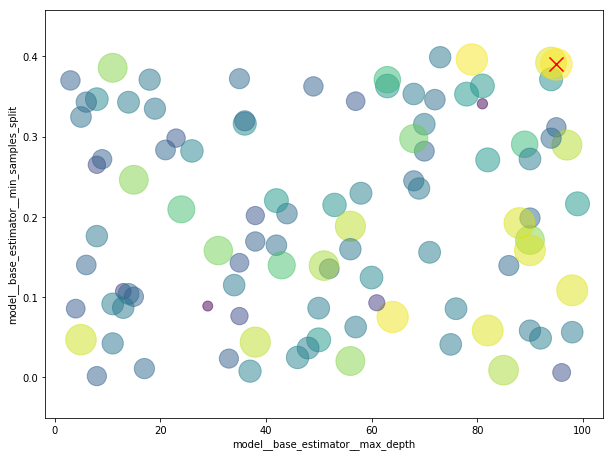

In [32]:
x_label = 'model__base_estimator__max_depth'
y_label = 'model__base_estimator__min_samples_split'
compare_two_parameters(x_label, y_label)

In [33]:
grid_search.best_score_, grid_search.best_params_

(0.7988506135758617,
 {'model__base_estimator__max_depth': 95,
  'model__base_estimator__max_features': 0.64871937760996,
  'model__base_estimator__min_samples_leaf': 0.01597658775176456,
  'model__base_estimator__min_samples_split': 0.3900287766606946,
  'model__n_estimators': 1869})

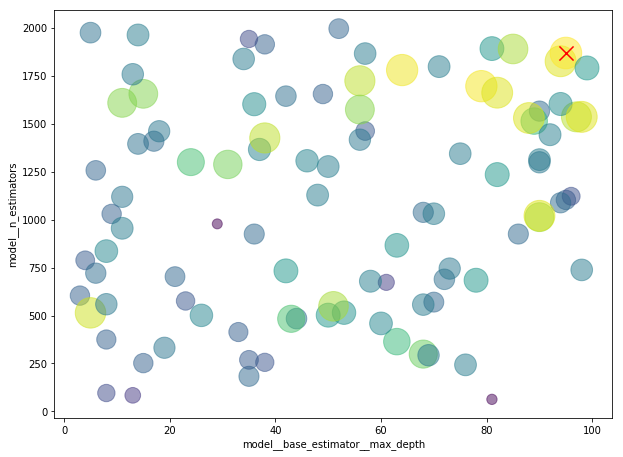

In [34]:
x_label = 'model__base_estimator__max_depth'
y_label = 'model__n_estimators'
compare_two_parameters(x_label, y_label)

In [35]:
grid_search.best_score_, grid_search.best_params_

(0.7988506135758617,
 {'model__base_estimator__max_depth': 95,
  'model__base_estimator__max_features': 0.64871937760996,
  'model__base_estimator__min_samples_leaf': 0.01597658775176456,
  'model__base_estimator__min_samples_split': 0.3900287766606946,
  'model__n_estimators': 1869})

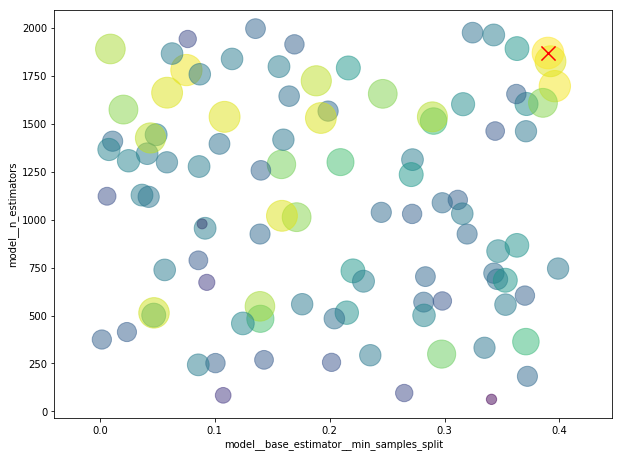

In [36]:
x_label = 'model__base_estimator__min_samples_split'
y_label = 'model__n_estimators'
compare_two_parameters(x_label, y_label)

In [37]:
grid_search.best_score_, grid_search.best_params_

(0.7988506135758617,
 {'model__base_estimator__max_depth': 95,
  'model__base_estimator__max_features': 0.64871937760996,
  'model__base_estimator__min_samples_leaf': 0.01597658775176456,
  'model__base_estimator__min_samples_split': 0.3900287766606946,
  'model__n_estimators': 1869})

reference:

```
N = 1000
r = range(0, N)
x = r
y = r
colors = r
area = r

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()
```

In [38]:
# column order is based off of the pipeline and FeatureUnion
    # cap_gain_loss_pipeline
    # num_pipeline
    # cat_pipeline
features = ['capital-gain', 'capital-loss'] + ['Net Capital'] + ['age', 'education-num', 'hours-per-week'] + one_hot_transformer.encoded_columns
importances = grid_search.best_estimator_.steps[1][1].feature_importances_

In [39]:
import pandas as pd
pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by=['importance'], ascending=False).head(20)

,feature,importance
2,Net Capital,0.194931
3,age,0.153743
0,capital-gain,0.140629
5,hours-per-week,0.098582
1,capital-loss,0.064262
4,education-num,0.040426
58,race_Black,0.015290
53,relationship_Own-child,0.015089
54,relationship_Unmarried,0.014130
34,marital-status_Separated,0.013528
